In [2]:
# import neccesary libraries

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats
from scipy.stats import iqr
from scipy.stats import gaussian_kde
import seaborn as sns

In [3]:
# read csv files into dataframes

test_features = pd.read_csv('kaggle_data/test_features.csv')
train_features = pd.read_csv('kaggle_data/train_features.csv')
tt_nonscored = pd.read_csv('kaggle_data/train_targets_nonscored.csv')
tt_scored = pd.read_csv('kaggle_data/train_targets_scored.csv')
ss = pd.read_csv('kaggle_data/sample_submission.csv')

In [4]:
# inspect dataframe

train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [5]:
# inspect dataframe

test_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


In [6]:
# inspect unique data types 

train_features.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [7]:
# create list of dataframes to funnel through functions to clean

dfs = [train_features, test_features]

In [8]:
# drop 'sig_id' column from dataframes, as this column provides a single value for each observation, and thus provides
# no level of categorical importance when fitting a model. Also, it represents an arbitrary name which otherwise holds no
# significance

full_dfs = [train_features, test_features, tt_scored]
def col_drop(df):
    df = df.drop(columns=['sig_id'], axis=1, inplace=True)
    return df
    
    
for df in full_dfs:
    col_drop(df)

In [9]:
# use mapping to replace 'object' data types with numerical values to fit the model

def cleaner(df):
    df['cp_type'] = df['cp_type'].map({'ctl_vehicle': 0, 'trt_cp': 1})
    df['cp_time'] = df['cp_time'].map({24: 1, 48: 2, 72: 3})
    df['cp_dose'] = df['cp_dose'].map({'D1': 0 , 'D2': 1})
    return df


for df in dfs:
    cleaner(df)

In [10]:
# keep observations where column 'cp_type' is of value 1. Before mapping, a value of 'ctl_vehicle' represented an observation
# that was referred to in hte industy as a 'control drug', meaning this sample is purely a placebo with no mechanism of 
# action. Removing these rows allows our model to be fit and tested with categorical data whose values and patterns exist
# from an experimental or approved drug, and not from a placebo.

keep_idx_test = test_features[test_features.cp_type != 0].index
keep_idx_train = train_features[train_features.cp_type != 0].index


train_features = train_features.loc[keep_idx_train]
test_features = test_features.loc[keep_idx_test]
tt_scored = tt_scored.loc[keep_idx_train]

In [11]:
# create lists of gene and cell expression column names for later use.
# create separate dataframes of gene and cell expression values for similarity testing among related features

g_cols = [col for col in train_features if 'g-' in col]
c_cols = [col for col in train_features if 'c-' in col]

gene_df = train_features.loc[:, 'g-0':'g-771']
cell_df = train_features.loc[:, 'c-0':]


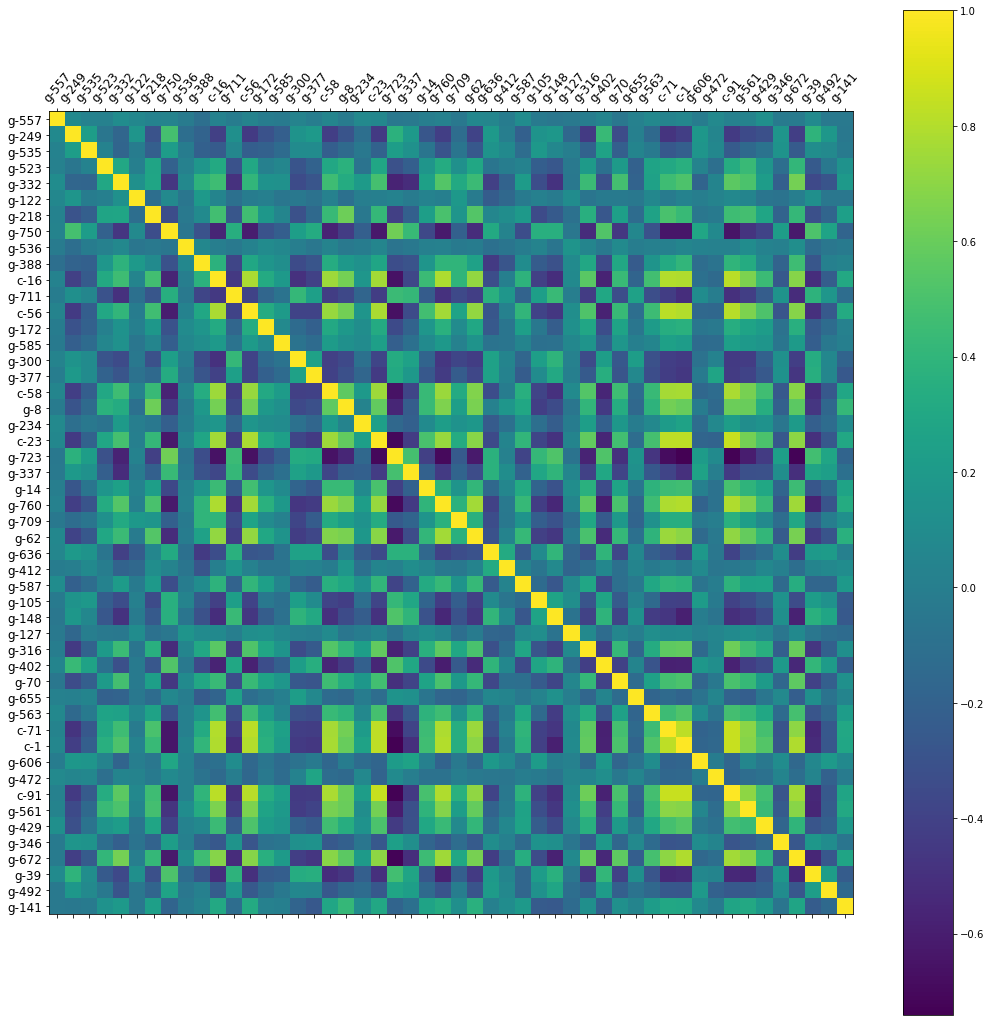

In [12]:
## pull random samples from the gene and cell expression features and express their correlations as a heatmap

cols = g_cols+c_cols
corr_cols = random.sample(cols, 50)
data = df[corr_cols]

f = plt.figure(figsize=(18,18))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=12, rotation=50)
plt.yticks(range(data.shape[1]), data.columns, fontsize=12)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

In [13]:
## find features with the highest correlation

cols = cols
top_cols = list()
for i in range(0, len(cols)):
    for j in range (i+1, len(cols)):
        if abs(train_features[cols[i]].corr(train_features[cols[j]])) > 0.9:
            top_cols = top_cols + [cols[i], cols[j]]\



In [14]:
## create list from set to pass over duplicates

top_cols = list(set(top_cols))


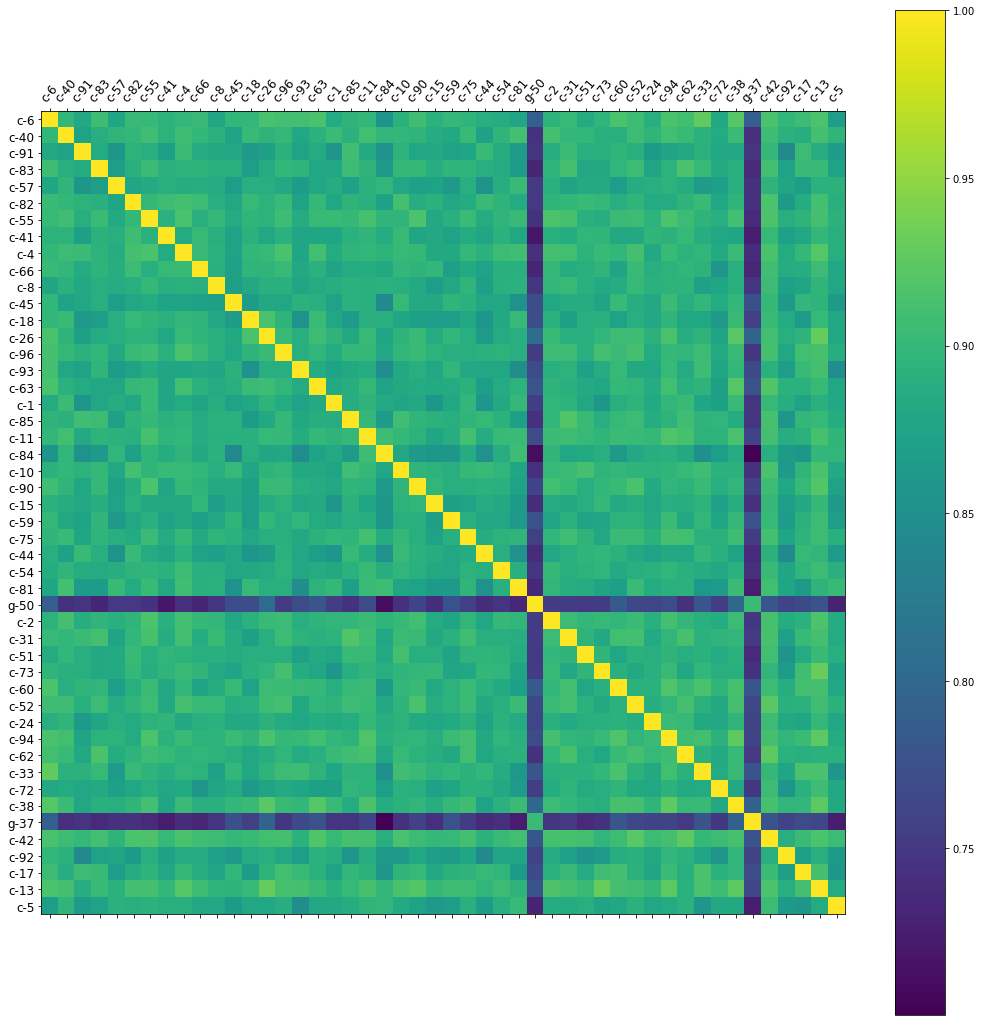

In [15]:
## plot the features with the highest correlation

corr_df = df[top_cols]

f = plt.figure(figsize=(18,18))
plt.matshow(corr_df.corr(), fignum=f.number)

plt.xticks(range(corr_df.shape[1]), corr_df.columns, fontsize=12, rotation=50)
plt.yticks(range(corr_df.shape[1]), corr_df.columns, fontsize=12)

cb = plt.colorbar()

In [16]:
# inspect dataframe again to verify changes 

gene_df.head()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,...,-0.5055,-0.3167,1.0930,0.0084,0.8611,-0.5582,0.3008,1.6490,0.2968,-0.0224
1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,...,-0.5338,0.0224,-0.4831,0.2128,-0.6999,-0.1214,-0.1626,-0.3340,-0.3289,-0.2718
2,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,...,2.5770,0.2356,1.3230,-1.3730,-0.2682,0.8427,0.5797,0.3143,0.8133,0.7923
3,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,...,-0.1292,3.4310,1.2720,-0.4733,-2.0560,0.5699,0.1996,0.4374,0.1588,-0.0343
4,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,...,-0.6904,2.0540,-0.3131,-0.0809,0.3910,1.7660,-1.0020,-0.7534,0.5000,-0.6269


In [17]:
# inspect dataframe again to verify changes

test_features.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,1,1,0,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,1,3,0,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
3,1,1,1,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,1,2,0,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380
6,1,2,1,0.3658,0.5536,-0.6898,-1.6270,0.5239,-0.3832,-0.4653,...,-0.8820,-0.5378,0.2314,-0.7602,-0.9982,-0.6570,-0.2593,-0.2174,0.0044,-1.4650


In [18]:
gene_df.shape, cell_df.shape

((21948, 772), (21948, 100))

In [19]:
## Find the features with the most and least unique values, and return their counts, respectively

dfs = [gene_df, cell_df]
vals = []
def finder(df):
    most_in_common = df.loc[:].nunique().idxmin()
    least_in_common = df.loc[:].nunique().idxmax() 
    
    most_count = np.unique(df.loc[:, most_in_common], return_counts=True)
    least_count = np.unique(df.loc[:, least_in_common], return_counts=True)
    most_count = most_count[1].max()
    least_count = least_count[1].max()
    
    vals.append(most_count)
    vals.append(least_count)
    

for df in dfs:
    finder(df)

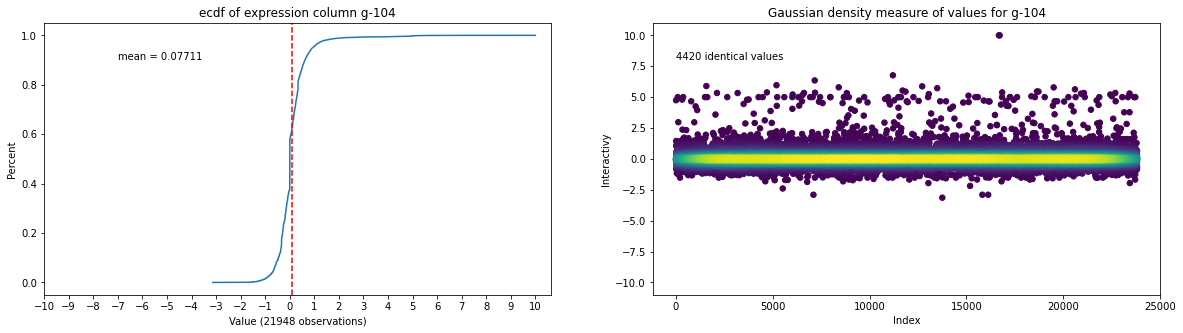

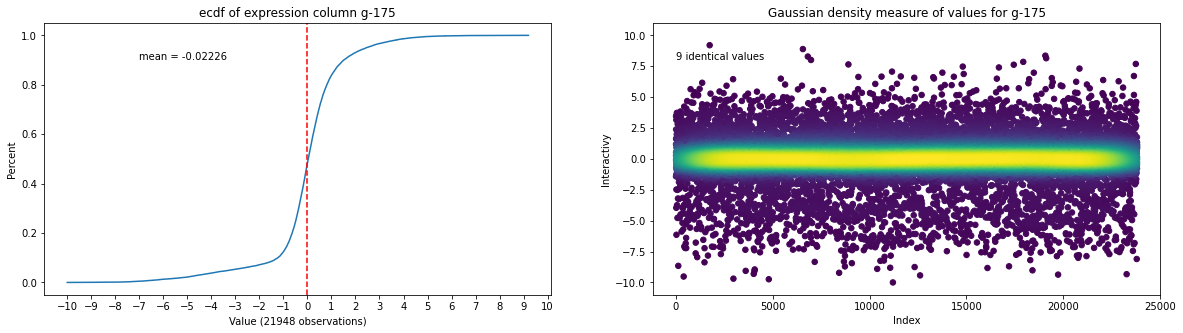

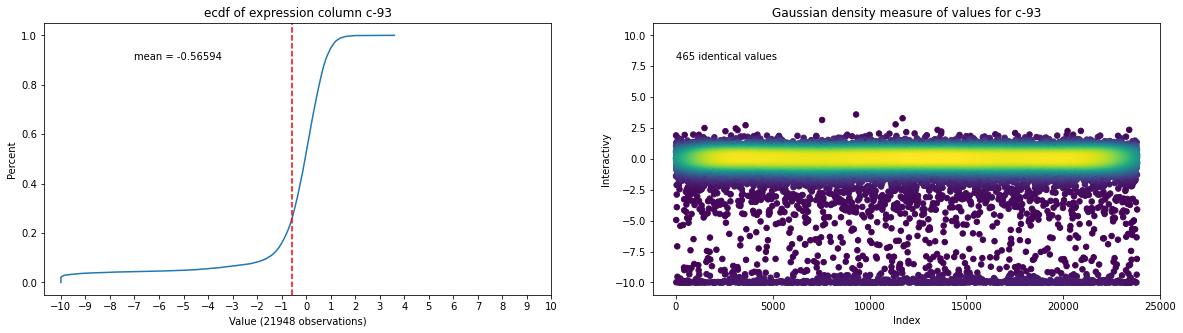

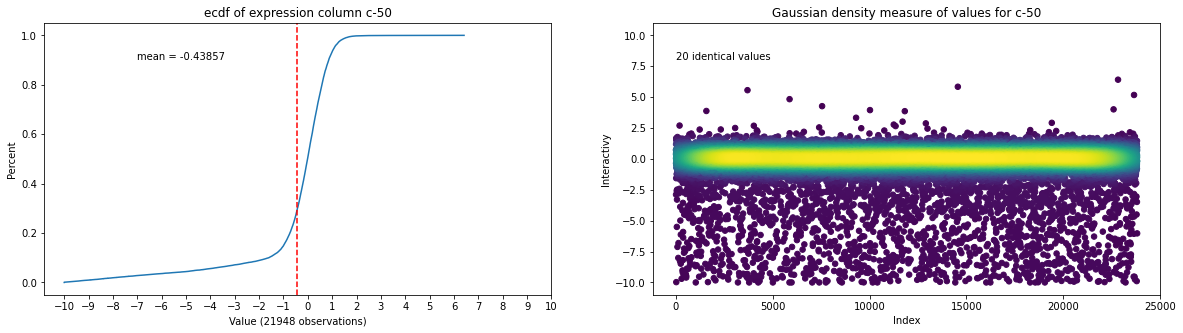

In [20]:
# create ECDF & Gaussian figures to show the distribution of each gene expression feature across all observations.  

series= [gene_df.loc[:, 'g-104'], gene_df.loc[:, 'g-175'], cell_df.loc[:, 'c-93'], cell_df.loc[:, 'c-50']]
columns = ['g-104', 'g-175', 'c-93', 'c-50']
text = 'Value (21948 observations)' 
dfs = [gene_df, gene_df, cell_df, cell_df]
vals = vals


def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, (n + 1)) /n
    return x, y

    
def plotter(x,y, data, column, text, df, val):
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    ax[0].plot(x,y)
    ax[0].axvline(np.mean(data), color='r', linestyle='--')
    ax[0].annotate('mean = ' + str(round(np.mean(data),5)), xy=(0, 0.9), xytext=(-7, 0.9))
    ax[0].set_title('ecdf of expression column ' + column)
    ax[0].set_xlabel(text)
    ax[0].set_ylabel('Percent')
    ax[0].set_xticks(range(-10, 11, 1))
    
    x = df.loc[:, column].index
    y = df.loc[:, column].values
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    ax[1].scatter(x, y, c=z, s=30)
    ax[1].set_ylim(-11, 11)
    ax[1].set_title('Gaussian density measure of values for ' + column)
    ax[1].set_xlabel('Index')
    ax[1].set_ylabel('Interactivy')
    ax[1].annotate((str(val) + ' identical values'), xy=(0,8), xytext=(0,8))
    plt.show()
    


for data, column, df, val in zip(series, columns, dfs, vals):
    x, y = ecdf(data)
    finder(df)
    plotter(x,y, data, column, text, df, val)

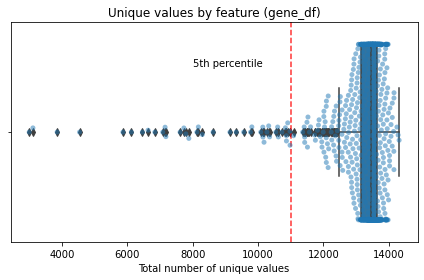

In [21]:
## visual of the number of unique values for each feature
## check cell_df, normally distributed, did not drop any feature
## '#' placed in front of used code, just uncomment and run

least_unique_list = []


def val_scatter(df):
    
    all_unique_val = df.loc[:].nunique()
    most_unique = all_unique_val.sort_values(ascending=False)[-42:]
    least_unique_list.append(most_unique)
    return all_unique_val


#plt.hist(val_scatter(cell_df), bins=100)
sns.boxplot(val_scatter(gene_df).values)
sns.swarmplot(val_scatter(gene_df).values, alpha=0.5)
plt.title('Unique values by feature (gene_df)')
plt.xlabel('Total number of unique values')
#plt.ylabel('Number of features')
plt.axvline(x=11000, linestyle='--', color = 'red', alpha=0.8)
plt.annotate('5th percentile', xy=(8000, -0.3))
plt.tight_layout()
plt.show()
#for idx, value in enumerate(unique_list):
    #plt.plot(idx, value)
    #plt.show()
#val_scatter(gene_df)


In [22]:
print(val_scatter(cell_df))

c-0     13832
c-1     14178
c-2     13865
c-3     13958
c-4     14017
        ...  
c-95    14023
c-96    13797
c-97    14102
c-98    14200
c-99    13950
Length: 100, dtype: int64


In [23]:
## find inter-quartile range constant
## multiply 1.5 by iqr to find constant

iqr = stats.iqr(val_scatter(gene_df))
constant = iqr * 1.5
constant

702.75

In [24]:
## anything below this value would be a suspected outlier
## 13160 represents 25% quartile (Q1)

13160-702.75


12457.25

In [25]:
## push threshold outside of normal outlier range to test hypothesis
## 94.56% of the features possess greater than 11000 unique values. Drop all values under 11000 before training model
## drop columns, improves log_loss eval of model by 0.00005


total = [x > 11000 for x in val_scatter(gene_df)]
total_above = []

for x in total:
    if x == True:
        x = 1
        total_above.append(x)
    else:
        x = 0
        total_above.append(x)
sum(total_above)/772 * 100

94.55958549222798

In [26]:
# List of features beyond the 5th percentile of unique interactivity measures.

least_unique_list

[g-496    10980
 g-333    10978
 g-676    10909
 g-127    10870
 g-39     10868
 g-360    10838
 g-28     10731
 g-19     10623
 g-184    10601
 g-110    10545
 g-687    10354
 g-216    10327
 g-15     10273
 g-626    10184
 g-393    10151
 g-667    10146
 g-164    10083
 g-688     9811
 g-754     9771
 g-557     9562
 g-363     9334
 g-132     9141
 g-435     8626
 g-536     8295
 g-550     8175
 g-481     8129
 g-611     7884
 g-18      7791
 g-756     7732
 g-331     7615
 g-618     7181
 g-718     7157
 g-370     7085
 g-219     6844
 g-153     6636
 g-46      6462
 g-238     6124
 g-23      5867
 g-707     4540
 g-213     3854
 g-307     3113
 g-104     2999
 dtype: int64,
 g-496    10980
 g-333    10978
 g-676    10909
 g-127    10870
 g-39     10868
 g-360    10838
 g-28     10731
 g-19     10623
 g-184    10601
 g-110    10545
 g-687    10354
 g-216    10327
 g-15     10273
 g-626    10184
 g-393    10151
 g-667    10146
 g-164    10083
 g-688     9811
 g-754     9771
 g-557   

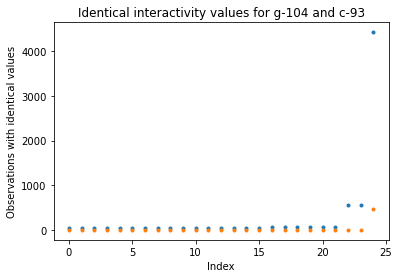

In [27]:

# visual of the two columns (one from gene_df, one from cell_df) with the most identical interactivity measurements 
# of a single value

dfs = [gene_df, cell_df]
alike = []
cols = []
def most_alike(df):
    most_in_common = df.loc[:].nunique().idxmin()
    most_count = np.unique(df.loc[:, most_in_common], return_counts=True)
    mc = most_count[1]
    cols = most_count[0]
    mc.sort()
    
    return mc[-25:]  


for df in dfs:
    alike.append(most_alike(df))
    
plt.plot(alike[0], marker='.', ls='')
plt.plot(alike[1], marker='.', ls='')
plt.title('Identical interactivity values for g-104 and c-93')
plt.xlabel('Index')
plt.ylabel('Observations with identical values')
plt.show()

In [28]:
# Tuple containing the features with the most unique values vs least unique values.
# Highlights the interactivity variation among gene expression features, and the lack-therof among the cell expression
# features

def variance(df):
    
    cols = df.nunique()
    x = cols.sort_values()
    return x[-1],x[0]


for df in dfs:
    difference = variance(df)
    print(difference)


(14317, 2999)
(14293, 13640)


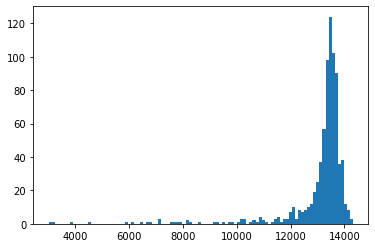

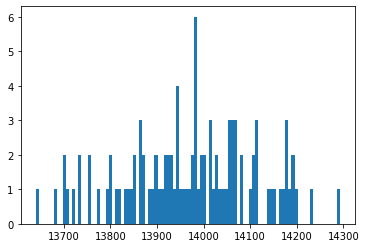

In [29]:
# Another way to code a plot for the uniqueness of values across the gene_df and cell_df

def variation_plotter(df):
    cols = df.loc[:].nunique()
    
    x = cols.sort_values()
    x = dict(x)
    unique_vals = x.values()
    
    plt.hist(unique_vals, bins=100)
    plt.show()
    

for df in dfs:
    variation_plotter(df)